In [1]:
!pip install pandas_ta
!pip install neat-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=be658427ef5d773936b4e16925b550df4eced43271270ff8dbf42203628c640f
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
use_collab = True
if use_collab:
  csv_dir = '/content/drive/MyDrive/eurusd_hour.csv'
  config_dir = '/content/drive/MyDrive/config-feedforward'
else:
  csv_dir = '/tmp/eurusd_hour.csv'
  config_dir = '/tmp/config-feedforward'

In [4]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import random
import neat
import string

In [5]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [6]:
df = pd.read_csv(csv_dir)
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


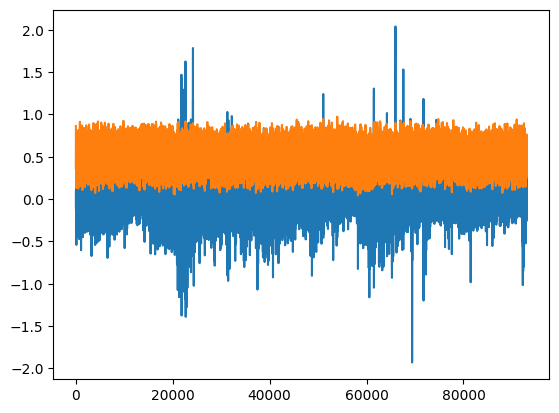

In [7]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8,scalar=50)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [8]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [9]:
def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

In [10]:
outputs = [.6,.7,.8,.10]
action = outputs[:3]
maxed = np.argmax(action)
print(maxed)

2


In [11]:
def run_env_loop(net,rand,debug):
    trade_info = np.zeros(4)
    returns = np.array([])

    trade_timer = 0
    trade_value = 0
    trade_direction = 0
    trade_max = 0
    cash_out_val = 0


    for count in range(rand, rand+1000):
        state = np.concatenate((INDICATORS[count], trade_info))
        outputs = net.activate(state)
        action = np.argmax(outputs)
        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        cur_move = change[count]

        if buy or sell:
          cash_out_value = trade_value
          trade_direction = 1 if buy else -1
          trade_value = ((cur_move*trade_direction)-.1)
          trade_max = trade_value
          trade_timer = 0
        elif cash_out:
          cash_out_value = trade_value
          trade_direction = 0
          trade_value = 0
          trade_max = 0
          trade_timer = 0
        else:
          cash_out_value = 0
          trade_value += cur_move*trade_direction if trade_direction != 0 else 0
          trade_max = max(trade_max,trade_value)
          trade_timer += .1


        trade_info = np.array((trade_direction,trade_value,trade_timer,trade_max))

        if cash_out_value != 0:
            returns = np.append(returns,cash_out_value)
        if debug:
          print(trade_info)
          print(cash_out_value)

    return np.sum(returns) if len(returns)>1 else 0

In [12]:
def run_env_loop(net,rand,debug):
    profit = 0
    bought = False
    sold = False
    trade_counter = 0
    for count in range(rand, rand+1000):
        outputs = net.activate(INDICATORS[count])
        action = 0 if outputs[0]>outputs[1] else 1

        if action == 0:
          profit += change[count+1]
          trade_counter += 1
          bought = True
        elif action == 1:
          sold = True
          profit += change[count+1]*-1
        else:
          profit += 0

        if debug:
          print([action,profit])


    trade_ratio = trade_counter/1000
    trade_ratio = abs(trade_ratio-.5)*1.5
    penelty = trade_ratio*abs(profit)

    if bought and sold:
      fitness = profit + -penelty
    else:
      fitness = -100

    return fitness

In [50]:
def eval_genomes(genomes, config):
  rand = random.randint(0, 70000)
  for genome_id, genome in genomes:
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    genome.fitness = run_env_loop(net,rand,False)


In [51]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_dir)

p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(False))
#p.add_reporter(neat.Checkpointer(100, 100,filename_prefix="/content/drive/MyDrive/neat/Neetcheckpoint/"))

In [52]:
winner = p.run(eval_genomes,100)


 ****** Running generation 0 ****** 

Population's average fitness: -63.90456 stdev: 47.64411
Best fitness: 26.35585 - size: (12, 44) - species 43 - id 43
Average adjusted fitness: 0.286
Mean genetic distance 3.584, standard deviation 0.276
Population of 300 members in 150 species
Total extinctions: 0
Generation time: 4.481 sec

 ****** Running generation 1 ****** 

Population's average fitness: -65.74964 stdev: 46.37163
Best fitness: 25.86484 - size: (13, 46) - species 72 - id 197
Average adjusted fitness: 0.272
Mean genetic distance 3.584, standard deviation 0.276
Population of 300 members in 150 species
Total extinctions: 0
Generation time: 10.194 sec (7.337 average)

 ****** Running generation 2 ****** 

Population's average fitness: -75.62998 stdev: 41.81753
Best fitness: 25.64445 - size: (12, 44) - species 60 - id 60
Average adjusted fitness: 0.194
Mean genetic distance 3.584, standard deviation 0.276
Population of 300 members in 150 species
Total extinctions: 0
Generation time:

In [53]:
net = neat.nn.FeedForwardNetwork.create(winner, config)

In [54]:
run_env_loop(net,70000,True)

[1, -0.7988013867545268]
[1, -1.7002730762560678]
[1, -1.7888450663531414]
[1, -1.9290689068926865]
[1, -4.600245369299845]
[1, -5.534328498365164]
[1, -6.768560305047326]
[1, -6.0129957242940675]
[1, -5.1098875666252725]
[1, -5.697922514861065]
[1, -6.645449491980862]
[1, -6.667459574075164]
[1, -6.726151551196527]
[1, -7.012254464984753]
[1, -6.190912109388469]
[0, -6.513905790737876]
[0, -5.919069521370612]
[1, -5.691581130072798]
[1, -5.610837046035936]
[0, -5.052913900122533]
[0, -5.001561176397351]
[0, -5.603083989869293]
[0, -6.087591858648021]
[0, -5.764395678864227]
[1, -5.08154557694268]
[0, -3.905770741195468]
[1, -3.0692304686326386]
[0, -3.6495301107469698]
[0, -3.0247149787154544]
[0, -2.855776060314287]
[0, -2.6721846191514844]
[1, -3.0613113661090936]
[1, -2.7604315461917146]
[1, -2.5401947827099054]
[0, -2.400674032537122]
[1, -2.2318092201024147]
[1, -2.040879250188621]
[0, -2.077605102015047]
[0, -1.893967619523886]
[0, -1.871936054756957]
[0, -1.4900658571383998]
[0

-7.844411571944967

In [55]:


def get_weights(connections, node_name,letter):
    node_weight = ""

    for key, value in connections.items():
        if value.enabled:
            if node_name == letter[value.key[1]]:
                if value.key[0] < 0:
                    from_node_name = "P" + str(value.key[0] * -1)
                    weight = value.weight
                else:
                    from_node_name = letter[value.key[0]]
                    weight = value.weight
                node_weight = node_weight + from_node_name + " * " + str(weight) + " + "


    return(node_weight)





In [56]:
nodes = winner.nodes
conec = winner.connections
node_list = []
letter_dict = dict()
count = 0



for index, node in nodes.items():
    letter_dict[index] = string.ascii_uppercase[count]
    count += 1

for index, node in nodes.items():
    node_name = letter_dict[index]
    activation = node.activation
    bias = str(node.bias) + ")"
    front = node_name + " = " + activation + "("
    weights = get_weights(conec,node_name,letter_dict)
    node_list.append((front+weights+bias))

node_list.reverse()






In [57]:
print(winner)

Key: 7604
Fitness: 39.5992013093501
Nodes:
	0 DefaultNodeGene(key=0, bias=0.040860372320391844, response=1.0, activation=identity, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=-2.4304265398230833, response=1.0, activation=abs, aggregation=sum)
	603 DefaultNodeGene(key=603, bias=-0.7377609977359878, response=1.0, activation=abs, aggregation=sum)
	606 DefaultNodeGene(key=606, bias=1.6444411532967487, response=1.0, activation=identity, aggregation=sum)
	607 DefaultNodeGene(key=607, bias=0.8025720723073365, response=1.0, activation=abs, aggregation=sum)
	608 DefaultNodeGene(key=608, bias=-0.9721775320973074, response=1.0, activation=abs, aggregation=sum)
	611 DefaultNodeGene(key=611, bias=1.7225460985763466, response=1.0, activation=abs, aggregation=sum)
	2990 DefaultNodeGene(key=2990, bias=-0.3179116165217865, response=1.0, activation=relu, aggregation=sum)
	3041 DefaultNodeGene(key=3041, bias=0.5474211028748757, response=1.0, activation=relu, aggregation=sum)
Connections:
	DefaultConn

In [58]:
for item in node_list:
       print(item)

I = relu(P1 * 1.9319062315476767 + H * 0.8415230280414117 + 0.5474211028748757)
H = relu(P2 * 0.37733104827453345 + -0.3179116165217865)
G = abs(1.7225460985763466)
F = abs(P2 * 2.752470078657781 + I * 0.6381712072630762 + -0.9721775320973074)
E = abs(G * -2.1194013010028017 + P2 * 0.46884834168093004 + 0.8025720723073365)
D = identity(P2 * 1.1191686921634076 + H * 3.9513831135425113 + B * 1.6536591788097703 + 1.6444411532967487)
C = abs(P1 * 0.6320701976923242 + P2 * 0.8517532705477244 + D * -0.7749555067716818 + -0.7377609977359878)
B = abs(E * -1.447717383921146 + F * -1.5838456978397466 + P1 * 1.4149285592498657 + -2.4304265398230833)
A = identity(P1 * -5.332177219676623 + 0.040860372320391844)
